In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.9.0

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as efficientnet_preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

Mounted at /content/drive
2.9.0


In [102]:
EPOCHS = 150
INIT_LR = 2e-4
batch_size = 16
input_shape=(224, 224, 3)

In [4]:
cateList = []
marksList = []
labelList = []
def loadImageData():
    imageList = []
    data_path = "/content/drive/My Drive/data"
    listCategories = os.listdir(data_path) # categories
    for cate_name in listCategories:
        cate_path=os.path.join(data_path,cate_name)
        listLandmarks=os.listdir(cate_path)
        for marks_name in listLandmarks:
          marks_path = os.path.join(cate_path,marks_name)
          image_names=os.listdir(marks_path)       
          for image_name in image_names:
            try:
              image_full_path = os.path.join(marks_path, image_name)
              image = tf.keras.utils.load_img(image_full_path)
              image_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(image)
              image_preprocessed = efficientnet_preprocess_input(image_resized)
              imageList.append(image_preprocessed)
              cateList.append(cate_name) 
              marksList.append(marks_name) 
            except:
              print("error occurred at: " + image_name)

    print("image size: " + str(len(imageList)))
    print("cate size: " + str(len(cateList)))
    print("mark size: " + str(len(marksList)))
    return imageList


In [5]:
imageArr = loadImageData()

error occurred at: Academy of Athens - 20.jpg
error occurred at: Buckingham Palace_19.jpg
error occurred at: Bibi Ka Maqbara - 14.jpg
image size: 417
cate size: 417
mark size: 417


In [6]:
cateList = np.array(cateList)
marksList = np.array(marksList)
labelList = np.stack((cateList, marksList), axis=1)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

trainX, valX = train_test_split(imageArr, test_size=0.2, random_state=42)
# Splitting categories
trainCate, valCate = train_test_split(cateList, test_size=0.2, random_state=42)

# Splitting landmarks
trainMarks, valMarks = train_test_split(marksList, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder
num_categories = 6
num_landmarks = 30
# Create a label encoder object
le_cate = LabelEncoder()
le_mark = LabelEncoder()

# Fit the encoder to the target categories and transform them to integer labels
trainCate = le_cate.fit_transform(trainCate)
valCate = le_cate.transform(valCate)
trainMarks = le_mark.fit_transform(trainMarks)
valMarks = le_mark.transform(valMarks)

# Convert the integer labels to one-hot encoded vectors
trainCate = to_categorical(trainCate, num_categories)
valCate = to_categorical(valCate, num_categories)

trainMarks = to_categorical(trainMarks, num_landmarks)
valMarks = to_categorical(valMarks, num_landmarks)

In [103]:
def build_model():
    input_shape = (224, 224, 3)
    inputs = layers.Input(shape=input_shape) 
    img_augmentation = Sequential([ 
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ])
    x = img_augmentation(inputs) # apply image augmentation
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x, input_shape=input_shape)
    for layer in base_model.layers[:127]:
      layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.1)(x)
    cate_output = layers.Dense(6, activation='softmax', name='cate_output')(x)
    marks_output = layers.Dense(30, activation='softmax', name='marks_output')(x)
    outputs = [cate_output, marks_output]
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='model')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
trainX = tf.reshape(trainX,shape=(333,224,224,3))
valX = tf.reshape(valX,shape=(84,224,224,3))

In [10]:
trainCate = tf.convert_to_tensor(trainCate)
valCate = tf.convert_to_tensor(valCate)
trainMarks = tf.convert_to_tensor(trainMarks)
valMarks = tf.convert_to_tensor(valMarks)

In [104]:
model = build_model()

In [12]:
print('traincate x:',trainX.shape)
print('traincate shape:',trainCate.shape)
print('trainmarks shape:',trainMarks.shape)

traincate x: (333, 224, 224, 3)
traincate shape: (333, 6)
trainmarks shape: (333, 30)


In [105]:
history = model.fit(trainX, [trainCate, trainMarks], 
                    epochs=EPOCHS, 
                    validation_data=(valX, [valCate, valMarks]),
)

Epoch 1/150


11/11 [==============================] - 14s 362ms/step - loss: 5.1246 - cate_output_loss: 1.7479 - marks_output_loss: 3.3767 - cate_output_accuracy: 0.2402 - marks_output_accuracy: 0.0541 - val_loss: 4.7038 - val_cate_output_loss: 1.4582 - val_marks_output_loss: 3.2456 - val_cate_output_accuracy: 0.5238 - val_marks_output_accuracy: 0.0833
Epoch 2/150
11/11 [==============================] - 2s 204ms/step - loss: 4.3054 - cate_output_loss: 1.3202 - marks_output_loss: 2.9853 - cate_output_accuracy: 0.6036 - marks_output_accuracy: 0.2462 - val_loss: 4.2141 - val_cate_output_loss: 1.1887 - val_marks_output_loss: 3.0255 - val_cate_output_accuracy: 0.7143 - val_marks_output_accuracy: 0.1786
Epoch 3/150
11/11 [==============================] - 2s 204ms/step - loss: 3.5571 - cate_output_loss: 0.9475 - marks_output_loss: 2.6096 - cate_output_accuracy: 0.8348 - marks_output_accuracy: 0.4685 - val_loss: 3.6506 - val_cate_output_loss: 0.9036 - val_marks_output_loss: 2.7470 - val_cate_output_accur

In [106]:
result= pd.DataFrame(history.history)

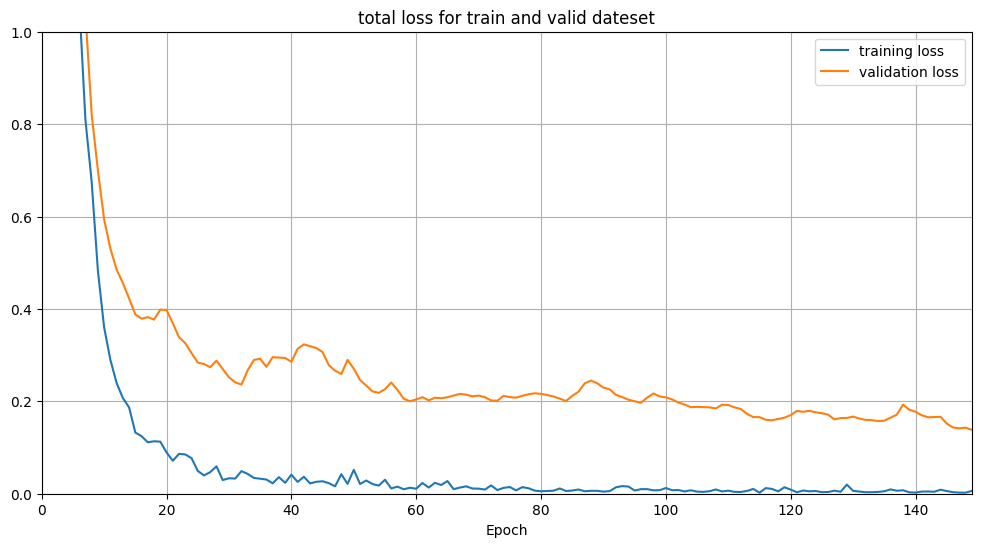

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(result["loss"],label = "training loss")
plt.plot(result["val_loss"],label = "validation loss")
plt.xlim([0,EPOCHS-1])
plt.ylim([0, 1])
plt.title("total loss for train and valid dateset")
plt.grid(True)
plt.xlabel("Epoch")
plt.legend()
plt.show()


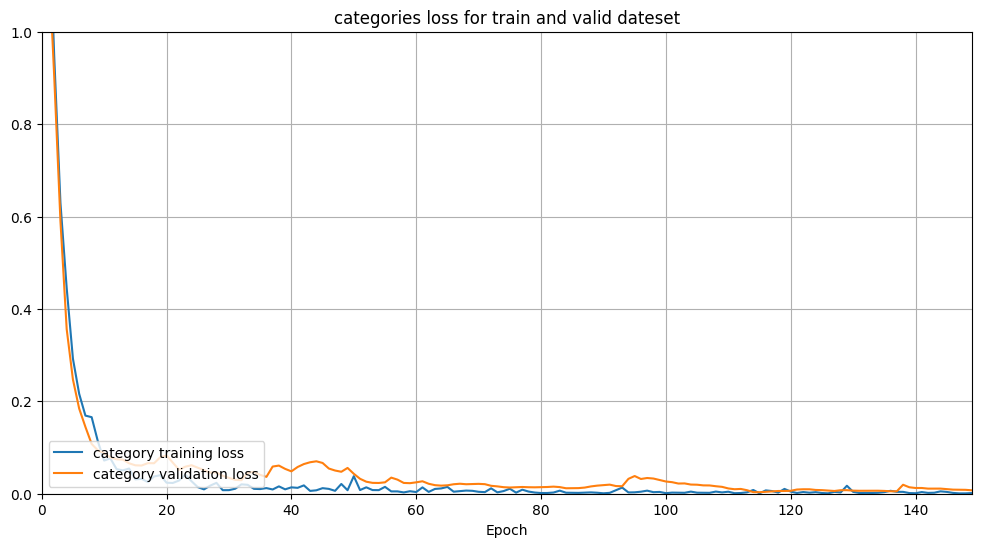

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(result["cate_output_loss"],label ="category training loss")
plt.plot(result["val_cate_output_loss"],label = "category validation loss")
plt.xlim([0,EPOCHS-1])
plt.ylim([0, 1])
plt.title("categories loss for train and valid dateset")
plt.grid(True)
plt.xlabel("Epoch")
plt.legend(loc=3)
plt.show()


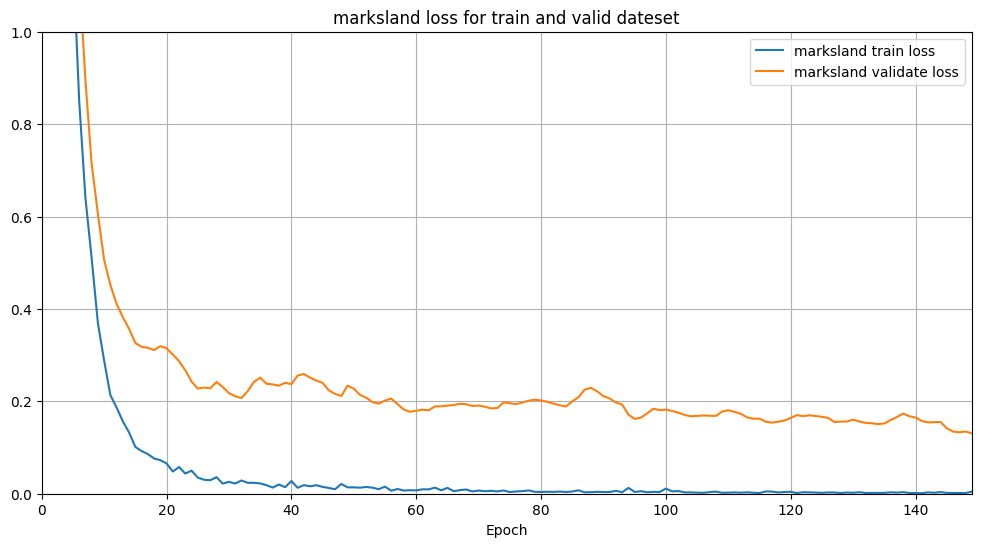

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(result["marks_output_loss"],label = "marksland train loss")
plt.plot(result["val_marks_output_loss"], label = "marksland validate loss")
plt.xlim([0,EPOCHS-1])
plt.ylim([0, 1])
plt.title("marksland loss for train and valid dateset")
plt.grid(True)
plt.xlabel("Epoch")
plt.legend()
plt.show()

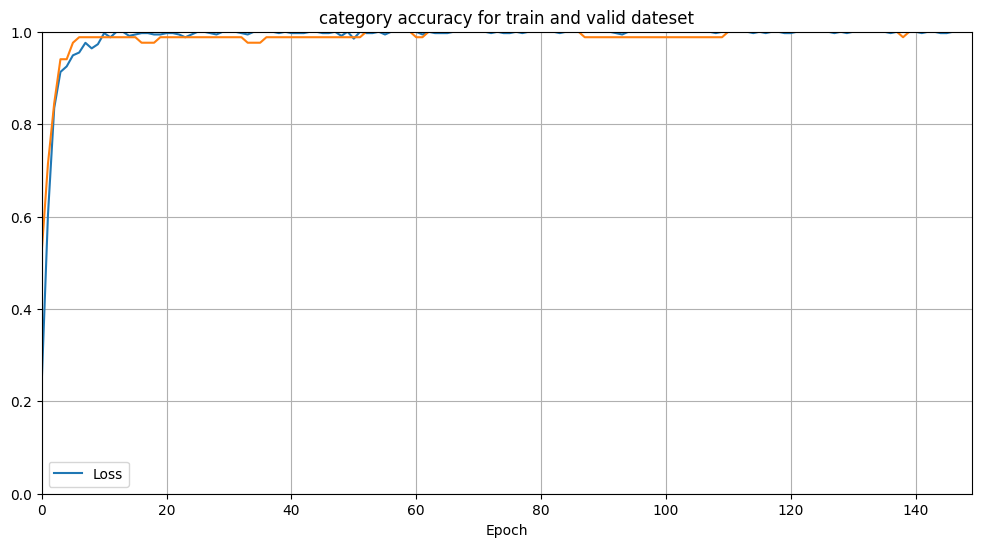

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(result["cate_output_accuracy"],label = "category train accuracy")
plt.plot(result["val_cate_output_accuracy"], label = " category validate accuracy")
plt.xlim([0,EPOCHS-1])
plt.ylim([0, 1])
plt.grid(True)
plt.title("category accuracy for train and valid dateset")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc=3)
plt.show()

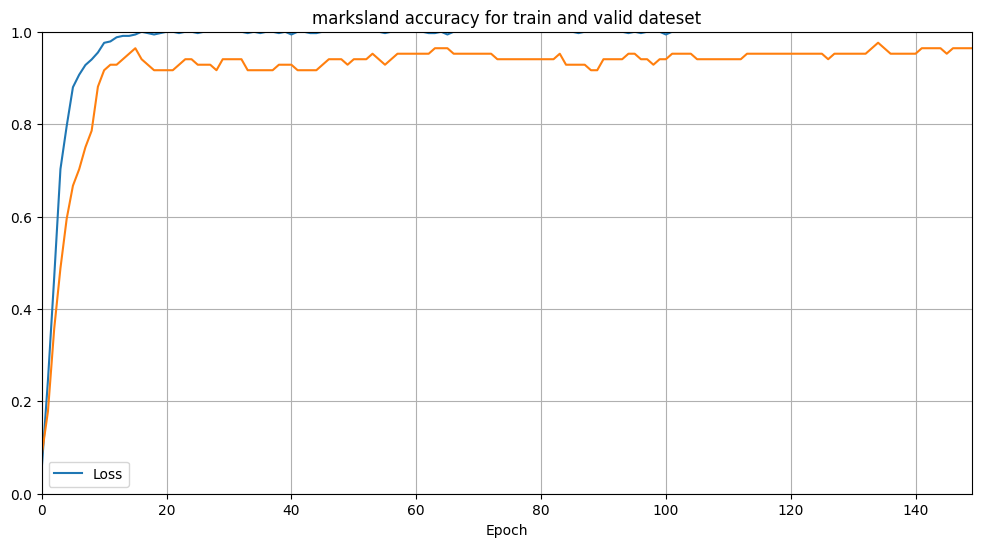

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(result["marks_output_accuracy"],label = "marksland train accuracy")
plt.plot(result["val_marks_output_accuracy"], label = "marksland validate accuracy")
plt.title("marksland accuracy for train and valid dateset")
plt.xlim([0,EPOCHS-1])
plt.ylim([0, 1])
plt.grid(True)
plt.xlabel("Epoch")
plt.legend(["Loss"], loc=3)
plt.show()

In [119]:
model.save("/content/drive/My Drive/final_model123.h5")

In [120]:

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

categories = ['Gothic', 'Modern', 'Mughal', 'Neoclassical', 'Pagodas', 'Pyramids']
landmarks = ['Academy of Athens', 'Bibi Ka Maqbara', 'Buckingham Palace',
 'CCTV Headquarters', 'Cathedral of Bras\ue4f2ia', 'ChartresCathedral',
 'Chrysler Building', 'CologneCathedral', 'Concertgebouw',
 'El Castillo, Chichen Itza', 'FogongTemplePagoda', 'GiantWildGoosePagoda',
 'Hallgr\ue4f3skirkja', 'Jama Masjid', 'Louvre Pyramid', 'MilanCathedral',
 'Notre-DameCathedral', 'Panthéon', 'Pyramid of Djoser', 'Pyramid of Giza',
 'Ripon Building', 'Santa Cecilia Acatitlan Pyramid', 'ShwedagonPagoda',
 'St.VitusCathedral', 'Taj Mahal', 'ThienMuPagoda', 'TianningTemplePagoda',
 'Tomb of Akbar', 'Tomb of I_timad-ud-Daulah', 'eiffel','other']

model = load_model("/content/drive/My Drive/final_model123.h5")

def model_prediction(directory):
    predictions = []
    cate_list = os.listdir(directory)
    for each_cate in cate_list:
      cate_path = os.path.join(directory, each_cate)
      mark_list = os.listdir(cate_path)
      for each_mark in mark_list:
        mark_path = os.path.join(cate_path, each_mark)
        file_list = os.listdir(mark_path)
        for file in file_list:
          try:
            img_path = os.path.join(mark_path, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=input_shape)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0) # Create batch axis
            
            # Make prediction
            cat_pred, landmark_pred = model.predict(img_array)

            
            # Get category and landmark with highest confidence
            cat_index = np.argmax(cat_pred)
            landmark_index = np.argmax(landmark_pred)

            
            # Calculate confidence scores
            cat_confidence = cat_pred[0][cat_index]
            landmark_confidence = landmark_pred[0][landmark_index]
            
            # Set landmark to "others" if confidence is too low
            if landmark_confidence < 0.5:
                landmark_index = 30
                landmark_confidence = 1 - landmark_confidence
            
            # Add prediction to list
            predictions.append({
                'image': file,
                'category': categories[cat_index],
                'category_confidence': cat_confidence,
                'landmark': landmarks[landmark_index],
                'landmark_confidence': landmark_confidence
            })
          except:
            print("load img failed: " + mark_path + "/" + file)


    # file_list = [f for f in file_list]
    # predictions = []
    # for file in file_list:
    #     img_path = os.path.join(directory, file)
    #     img = tf.keras.preprocessing.image.load_img(img_path, target_size=input_shape)
    #     img_array = tf.keras.preprocessing.image.img_to_array(img)
    #     img_array = tf.expand_dims(img_array, 0) # Create batch axis
        
    #     # Make prediction
    #     cat_pred, landmark_pred = model.predict(img_array)

        
    #     # Get category and landmark with highest confidence
    #     cat_index = np.argmax(cat_pred)
    #     landmark_index = np.argmax(landmark_pred)

        
    #     # Calculate confidence scores
    #     cat_confidence = cat_pred[0][cat_index]
    #     landmark_confidence = landmark_pred[0][landmark_index]
        
    #     # Set landmark to "others" if confidence is too low
    #     if landmark_confidence < 0.5:
    #         landmark_index = 30
    #         landmark_confidence = 1 - landmark_confidence
        
    #     # Add prediction to list
    #     predictions.append({
    #         'image': file,
    #         'category': categories[cat_index],
    #         'category_confidence': cat_confidence,
    #         'landmark': landmarks[landmark_index],
    #         'landmark_confidence': landmark_confidence
    #     })
    
    # Create DataFrame from list of predictions
    prediction_df = pd.DataFrame(predictions)
    print(prediction_df)
    
    return prediction_df

pred = model_prediction("/content/drive/My Drive/data")


1/1 [==============================] - 0s 30ms/step
load img failed: /content/drive/My Drive/data/Neoclassical/Academy of Athens/Academy of Athens - 20.jpg
1/1 [==============================] - 0s 31ms/step
load img failed: /content/drive/My Drive/data/Neoclassical/Buckingham Palace/Buckingham Palace_19.jpg
1/1 [==============================] - 0s 29ms/step
load img failed: /content/drive/My Drive/data/Mughal/Bibi Ka Maqbara/Bibi Ka Maqbara - 14.jpg
1/1 [==============================] - 0s 28ms/step
                                image  category  category_confidence  \
0             St.VitusCathedral0.jpeg    Gothic             0.999863   
1             St.VitusCathedral1.jpeg    Gothic             0.999982   
2             St.VitusCathedral4.jpeg    Gothic             0.999829   
3             St.VitusCathedral5.jpeg    Gothic             0.999995   
4             St.VitusCathedral8.jpeg    Gothic             0.999873   
..                                ...       ...             

In [121]:
pred

,image,category,category_confidence,landmark,landmark_confidence
0,St.VitusCathedral0.jpeg,Gothic,0.999863,St.VitusCathedral,0.953727
1,St.VitusCathedral1.jpeg,Gothic,0.999982,St.VitusCathedral,0.999773
2,St.VitusCathedral4.jpeg,Gothic,0.999829,St.VitusCathedral,0.996476
3,St.VitusCathedral5.jpeg,Gothic,0.999995,St.VitusCathedral,0.997651
4,St.VitusCathedral8.jpeg,Gothic,0.999873,St.VitusCathedral,0.985468
...,...,...,...,...,...
412,"El Castillo, Chichen Itza-14.jpg",Pyramids,0.645178,Santa Cecilia Acatitlan Pyramid,0.815378
413,"El Castillo, Chichen Itza-15.jpg",Pyramids,0.995754,"El Castillo, Chichen Itza",0.998175
414,"El Castillo, Chichen Itza-16.jpg",Pyramids,0.997008,"El Castillo, Chichen Itza",0.999843
415,"El Castillo, Chichen Itza-18.jpg",Pyramids,0.999468,"El Castillo, Chichen Itza",0.906479


In [122]:
from sklearn.metrics import f1_score

# assuming y_true and y_pred are the true and predicted labels, respectively
f1_cate = f1_score(cateList, pred["category"], average='weighted')
f1_mark = f1_score(marksList, pred["landmark"], average='weighted')
print('F1 score:', f1_cate)
print('F1 score:', f1_mark)


F1 score: 1.0
F1 score: 0.9866501675812848


In [116]:
# Run the function of model prediction
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [117]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [118]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###
